# PPO
---

### 1. Import the Necessary Packages

In [1]:
%matplotlib inline
import wandb
import torch
from model.ppo_3 import PPO
import numpy as np
from env.wrappers import LunarContinuous, LunarLanderWithUnknownWind,LunarLanderWithKnownWind
from utils.logger import WandbSummaryWritter

### 2. Instantiate the Model

Setup the hyperparameters in the code cell below.

In [2]:
misc_hyperparameters = {
    'save_freq': 0 ,  
    'val_freq': 10,
    'val_iter': 10,
    'env': LunarLanderWithUnknownWind
}

Initialise wandb session in the code cell below.

In [3]:
VAL_ITER = 100
MAX_RUN_COUNT = 30
sweep_config = {
    'method': 'bayes', 
    'metric': {
        'name': 'validation_rewards',
        'goal': 'maximize'
    },
    'parameters': {
        'actor_lr': {
            "distribution": "uniform",
            "min": 1e-5,
            "max": 0.1
        },
        'critic_lr': {
            "distribution": "uniform",
            "min": 1e-5,
            "max": 0.1
        },
        'adp_lr': {
            "distribution": "uniform",
            "min": 1e-5,
            "max": 0.1
        },
        'gamma': {
            'min': 0.9,
            'max': 1.
        },
        'lam': {
            'min': 0.9,
            'max': 1.
        },
        'max_grad_norm': {
            "min": 0.1,
            "max": 10.0, 
        },
        'n_updates_per_iteration': {
            'values': list(range(1, 21))
        },
        'num_envs': {
            'values': list(range(1, 100))
        },
        'anneal_lr': {
            'values': [True, False]
        },
        # 'num_steps': {
        #     'distribution': 'q_uniform',
        #     'min': 300,
        #     'max': 4000,
        #     'q': 100
        # },
        # 'adp_num_steps': {
        #     'distribution': 'q_uniform',
        #     'min': 200,
        #     'max': 1000,
        #     'q': 10
        # },
        'num_steps': {
            'distribution': 'q_uniform',
            'min': 3,
            'max': 4,
            'q': 1
        },
        'adp_num_steps': {
            'distribution': 'q_uniform',
            'min': 2,
            'max': 10,
            'q': 1
        },
        'anneal_discount': {
            'distribution': 'q_uniform',
            'min': 1,
            'max': 1000,
            'q': 10
        },
        'batches': {
            'distribution': 'q_uniform',
            "min": 1,     # 2^0
            "max": 1024,  # 2^10
            "q": 2 
        }
    }
}

In [4]:
def train_model(config = None):
    logger = WandbSummaryWritter(project='lunar', config =config)
    ppo = PPO(logger,**misc_hyperparameters) if config is None else PPO(summary_writter=logger, **config, **misc_hyperparameters)
    ppo.train()

    base_val_rews, base_val_dur = ppo.validate(VAL_ITER, False, False)
    adp_val_rews, adp_val_dur = ppo.validate(VAL_ITER, False, True)
    # wind_vals, base_z, adpt_z = ppo.validate_encoders()
    ppo.env.close()

    # hist, bin_edges = np.histogram(val_rews, bins=20)
    # print(f"Len bin_edges: {len(bin_edges)}")
    # Debugging prints
    wandb.log({
        "validation_rewards": base_val_rews,
        "validation_duration": base_val_dur,
        "maximum_base_validation_reward": np.max(base_val_rews),
        "adp_validation_rewards": adp_val_rews,
        "adp_validation_duration": adp_val_dur,
        "adp_maximum_base_validation_reward": np.max(adp_val_rews),

        # "Encoder Outputs": wandb.plot.line_series(
        #         xs=wind_vals,
        #         ys=[base_z, adpt_z],
        #         keys=["Base Encoder", "Adaptive Encoder"],
        #         title="Encoder Outputs vs Wind",
        #         xname="Wind Value"
        #     )

        # "max_reward_video": wandb.Video(f"./videos/rl-video{np.argmax(adp_val_rews)}-episode-{np.argmax(adp_val_rews)}.mp4", fps=4, format="mp4")
    })
    logger.save_histogram(base_val_rews, "Base Validation Rewards")
    logger.save_histogram(base_val_dur, "Base Validation Duration")
    logger.save_histogram(adp_val_rews, "Adaptive Validation Rewards")
    logger.save_histogram(adp_val_dur, "Adaptive Validation Duration")
    logger.save_model(ppo.policy, "base_model")
    logger.save_model(ppo.adapt_policy, "adp_model")

Initialise the model fo the desired timestamps. Alternatively can specify a checkpoint to continue training.

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="lunar")
wandb.agent(sweep_id, function=train_model, count=MAX_RUN_COUNT)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: din7yjzt
Sweep URL: https://wandb.ai/pmsaraiva2712-tum/lunar/sweeps/din7yjzt


wandb: Agent Starting Run: 7qjjo3pm with config:
wandb: 	actor_lr: 0.01750460963455694
wandb: 	adp_lr: 0.06976077981411181
wandb: 	adp_num_steps: 9
wandb: 	anneal_discount: 130
wandb: 	anneal_lr: False
wandb: 	batches: 270
wandb: 	critic_lr: 0.017762192683779543
wandb: 	gamma: 0.966874864109502
wandb: 	lam: 0.9216071602403736
wandb: 	max_grad_norm: 3.7877046862925456
wandb: 	n_updates_per_iteration: 18
wandb: 	num_envs: 74
wandb: 	num_steps: 3
wandb: Currently logged in as: pmsaraiva2712 (pmsaraiva2712-tum). Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



-------------------- Iteration #1 --------------------
Average Episodic Return: -159.36
Average Actor Loss: -0.21156
Average Critic Loss: 1063.2504741375262
Average KL Divergence: 0.011137695863502672
Iteration took: 11.37 secs, of which rollout took 9.22 secs and gradient updates took 2.14 secs
Current actor learning rate: 0.005
Current critic learning rate: 0.0075
------------------------------------------------------


-------------------- Iteration #1 --------------------
Average adp Loss: 0.00424
Iteration took: 9.97 secs, of which rollout took 9.23 secs and gradient updates took 0.72 secs
Current adp learning rate: 0.005
------------------------------------------------------



actor_learning_rate,▁
adp_learning_rate,▁
adp_maximum_base_validation_reward,▁
average_actor_loss,▁
average_adapt_loss,▁
average_critic_loss,▁
average_episode_rewards,▁
critic_learning_rate,▁
iteration_compute,█▁
maximum_base_validation_reward,▁
simulated_iterations,▁▁


wandb: Agent Starting Run: fl2v6ixe with config:
wandb: 	actor_lr: 0.06342674451654909
wandb: 	adp_lr: 0.05996598873493763
wandb: 	adp_num_steps: 4
wandb: 	anneal_discount: 170
wandb: 	anneal_lr: True
wandb: 	batches: 730
wandb: 	critic_lr: 0.037878897529723246
wandb: 	gamma: 0.9104554043857758
wandb: 	lam: 0.9961020943532246
wandb: 	max_grad_norm: 2.9220242655710686
wandb: 	n_updates_per_iteration: 2
wandb: 	num_envs: 17
wandb: 	num_steps: 3
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



-------------------- Iteration #1 --------------------
Average Episodic Return: -345.0
Average Actor Loss: -0.20789
Average Critic Loss: 1433.663720350999
Average KL Divergence: 0.010454763821326197
Iteration took: 12.07 secs, of which rollout took 10.11 secs and gradient updates took 1.96 secs
Current actor learning rate: 0.005
Current critic learning rate: 0.0075
------------------------------------------------------


-------------------- Iteration #1 --------------------
Average adp Loss: 0.00088
Iteration took: 9.94 secs, of which rollout took 9.29 secs and gradient updates took 0.64 secs
Current adp learning rate: 0.005
------------------------------------------------------



actor_learning_rate,▁
adp_learning_rate,▁
adp_maximum_base_validation_reward,▁
average_actor_loss,▁
average_adapt_loss,▁
average_critic_loss,▁
average_episode_rewards,▁
critic_learning_rate,▁
iteration_compute,█▁
maximum_base_validation_reward,▁
simulated_iterations,▁▁


wandb: Agent Starting Run: h86xf14d with config:
wandb: 	actor_lr: 0.0887682885830194
wandb: 	adp_lr: 0.005795469900956493
wandb: 	adp_num_steps: 3
wandb: 	anneal_discount: 10
wandb: 	anneal_lr: True
wandb: 	batches: 320
wandb: 	critic_lr: 0.05119560384515642
wandb: 	gamma: 0.9264558666258343
wandb: 	lam: 0.9972288249757916
wandb: 	max_grad_norm: 6.938674129869852
wandb: 	n_updates_per_iteration: 11
wandb: 	num_envs: 37
wandb: 	num_steps: 3
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



-------------------- Iteration #1 --------------------
Average Episodic Return: -244.69
Average Actor Loss: -0.20861
Average Critic Loss: 2235.108587881235
Average KL Divergence: 0.012463074138996978
Iteration took: 12.06 secs, of which rollout took 10.12 secs and gradient updates took 1.94 secs
Current actor learning rate: 0.005
Current critic learning rate: 0.0075
------------------------------------------------------



In [6]:
api = wandb.Api()

# Fetch the sweep object
sweep = api.sweep(f"pmsaraiva2712-tum/lunar/{sweep_id}")

# Fetch all runs from the sweep
runs = sweep.runs

# Sort runs by the metric you are optimizing for, e.g., 'val_loss'
best_run = sorted(runs, key=lambda run: run.summary.get('val_rewards', float('-inf')), reverse=True)[0]

# Extract best hyperparameters and metrics
best_params = best_run.config
best_metrics = best_run.summary

# Print the best hyperparameters and metrics
print("Best Hyperparameters:", best_params)
print("Best Metrics:", best_metrics)

Exception in thread Exception in threading.excepthook:
Exception ignored in thread started by: <bound method Thread._bootstrap of <Thread(Thread-26 (_run_job), stopped 140260891666112)>>
Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 995, in _bootstrap
    self._bootstrap_inner()
  File "/usr/lib/python3.11/threading.py", line 1040, in _bootstrap_inner
    self._invoke_excepthook(self)
  File "/usr/lib/python3.11/threading.py", line 1352, in invoke_excepthook
    local_print("Exception in threading.excepthook:",
  File "/home/mohamedrostom62/ADLR/tum-adlr-ws25-16/.venv/lib/python3.11/site-packages/ipykernel/iostream.py", line 604, in flush
    self.pub_thread.schedule(self._flush)
  File "/home/mohamedrostom62/ADLR/tum-adlr-ws25-16/.venv/lib/python3.11/site-packages/ipykernel/iostream.py", line 267, in schedule
    self._event_pipe.send(b"")
  File "/home/mohamedrostom62/ADLR/tum-adlr-ws25-16/.venv/lib/python3.11/site-packages/zmq/sugar/socket.py", l

Best Hyperparameters: {'lam': 0.972831062901546, 'gamma': 0.9762351550544416, 'adp_lr': 0.09927788245027704, 'batches': 332, 'actor_lr': 0.09110289758146364, 'num_envs': 57, 'anneal_lr': False, 'critic_lr': 0.07641949481794698, 'num_steps': 400, 'adp_num_steps': 800, 'max_grad_norm': 0.9648681113993745, 'anneal_discount': 330, 'n_updates_per_iteration': 7}
Best Metrics: {'_runtime': 1381.245859275, '_step': 129, '_timestamp': 1736364925.640216, '_wandb': {'runtime': 1381}, 'actor_learning_rate': 0.005, 'average_actor_loss': -0.2133525514073367, 'average_critic_loss': 87.58824276961218, 'average_episode_rewards': 125.1359634399414, 'critic_learning_rate': 0.0075, 'iteration_compute': 7.647851373, 'simulated_iterations': 119, 'val_durs': 1201, 'val_rews': 124.9922409408134}


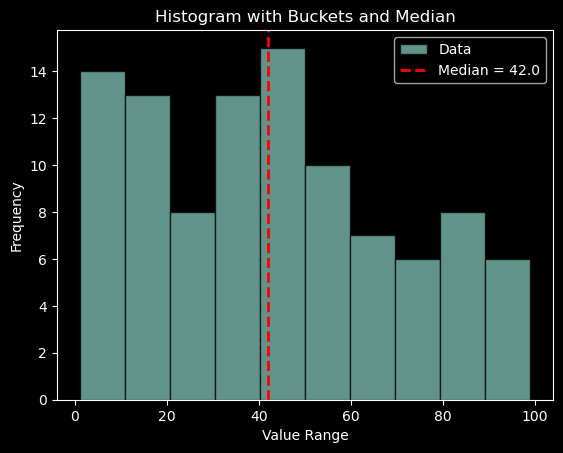

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example NumPy array
data = np.random.randint(0, 100, size=100)  # Random integers between 0 and 100

# Calculate the median
median_value = np.median(data)

# Create histogram
num_bins = 10  # Number of buckets
plt.hist(data, bins=num_bins, edgecolor='black', alpha=0.7, label='Data')

# Add a vertical line for the median
plt.axvline(median_value, color='red', linestyle='dashed', linewidth=2, label=f'Median = {median_value}')

# Add labels, title, and legend
plt.xlabel('Value Range')
plt.ylabel('Frequency')
plt.title('Histogram with Buckets and Median')
plt.legend()

# Show the plot
plt.show()